# Library

## install

In [ ]:
! pip install -q torchmetrics

## import

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.2.2
cv2 --> 4.11.0
PIL --> 11.1.0
sklearn --> 1.6.1
torch --> 2.5.1+cu124
torchvision --> 0.20.1+cu124
tqdm --> 4.67.1
torchmetrics --> 1.6.1


------------------

# Utils

## avragemeter

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## number of parameter fn

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------

# Data



In [ ]:
data_path= r'/content/drive/MyDrive/Catalist/0_age estimation/UTKFace.tar.gz'
! tar -xzf "{data_path}" -C '/content/'

--------

# EDA

## show sample of images

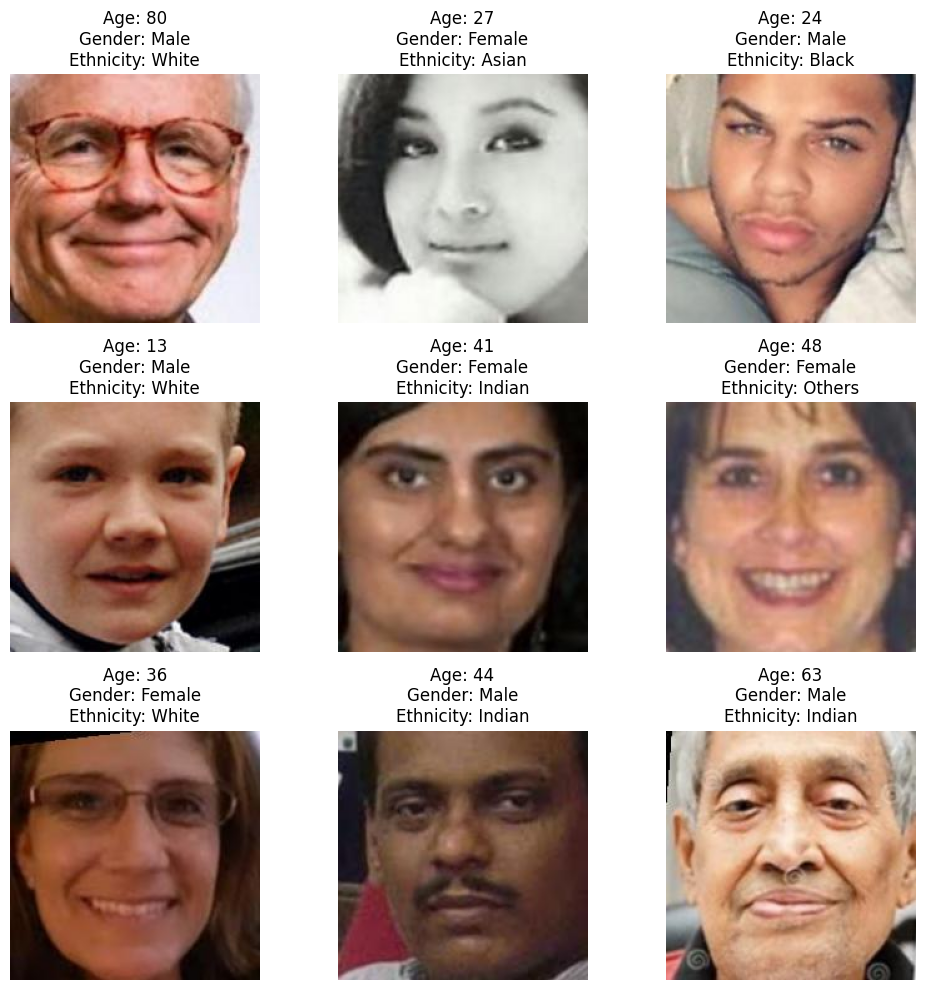

In [ ]:
dataset_folder= '/content/UTKFace/'

def show_random_samples(num_samples= 9):
    image_files= os.listdir(dataset_folder)
    selected_image_files= random.sample(image_files, num_samples)

    plt.figure(figsize= (10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path= os.path.join(dataset_folder, image_file)
        age, gender, ethnicity= image_file.split('_')[:3]

        image = Image.open(image_path)

        gender= 'Male' if int(gender)== 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples()

## create csv file contain list of images

In [ ]:
dataset_dir= '/content/UTKFace'
image_names= []
ages= []
ethnicities= []
genders= []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.jpg'):

        parts= filename.split('_')
        if len(parts) < 4:
          print(filename)
          continue

        age= int(parts[0])
        gender= 'Male' if int(parts[1]) == 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]

        if age > 80:
          continue

        image_names.append(filename)
        ages.append(age)
        ethnicities.append(ethnicity)
        genders.append(gender)

data= {
    'image_name': image_names,
    'age': ages,
    'ethnicity': ethnicities,
    'gender': genders
}
df= pd.DataFrame(data)

csv_filename = '/content/utkface_dataset.csv'
df.to_csv(csv_filename, index=False)
# df.to_csv('/content/drive/MyDrive/Catalist/0_age estimation/utkface_dataset.csv', index=False)

print(f"CSV file '{csv_filename}' created successfully.")

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg
CSV file '/content/utkface_dataset.csv' created successfully.


In [ ]:
df

,image_name,age,ethnicity,gender
0,75_0_0_20170111205739880.jpg.chip.jpg,75,White,Male
1,26_0_0_20170117201346990.jpg.chip.jpg,26,White,Male
2,26_1_2_20170116180538949.jpg.chip.jpg,26,Asian,Female
3,32_0_0_20170120220945196.jpg.chip.jpg,32,White,Male
4,1_0_2_20161219190831555.jpg.chip.jpg,1,Asian,Male
...,...,...,...,...
23160,8_0_0_20170117182551223.jpg.chip.jpg,8,White,Male
23161,26_0_0_20170116232422006.jpg.chip.jpg,26,White,Male
23162,58_0_0_20170111201757951.jpg.chip.jpg,58,White,Male
23163,27_1_4_20170116180404068.jpg.chip.jpg,27,Others,Female


## histogram

### age

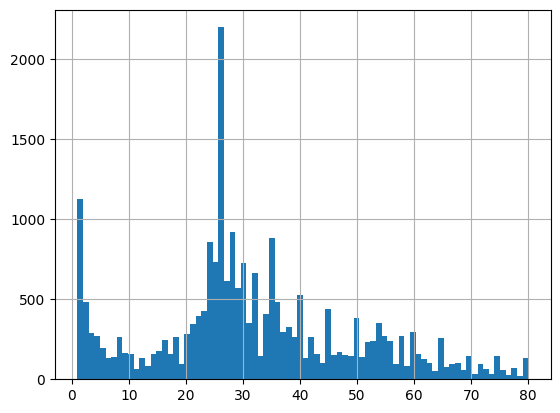

In [ ]:
df['age'].hist(bins= len(df.age.unique()));

### gender

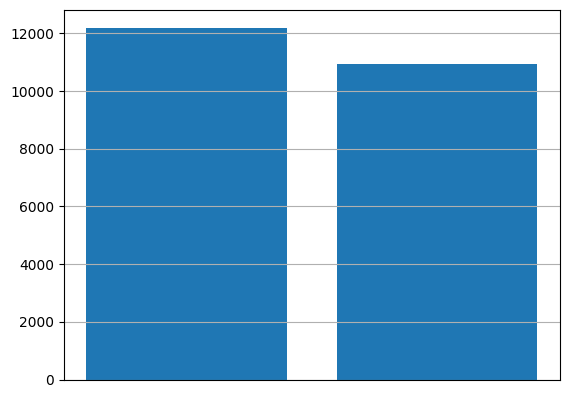

In [ ]:
df['gender'].hist(bins= len(df.gender.unique()), rwidth= 0.8);

In [ ]:
df.gender.value_counts()

,count
gender,
Male,12208
Female,10957


### race

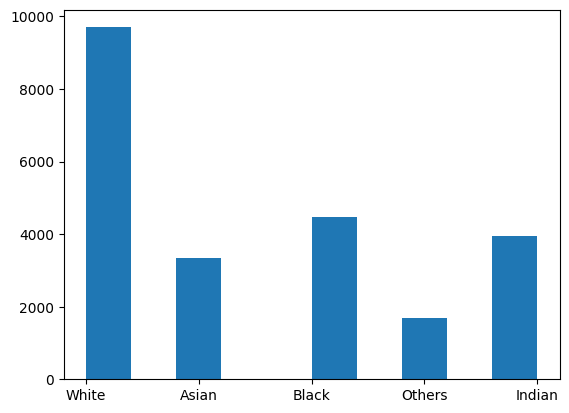

In [ ]:
plt.hist(df.ethnicity);

## crosstab

### age-race

In [ ]:
pd.crosstab(df.gender, df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


## boxplot & violinplot

### gender

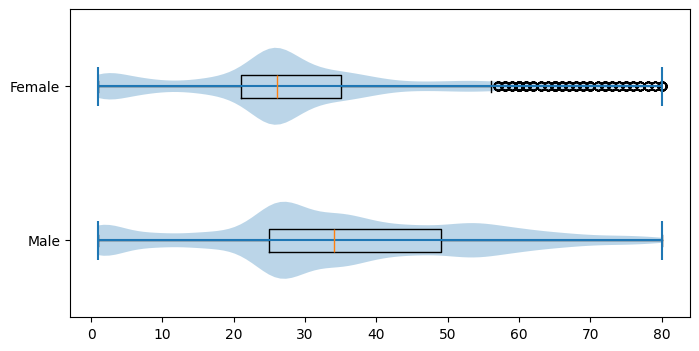

In [ ]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.gender== sex] for sex in df.gender.unique()],
            tick_labels= df.gender.unique(),
            vert= False)
plt.violinplot([df.age[df.gender== sex] for sex in df.gender.unique()],
               vert= False);

### race

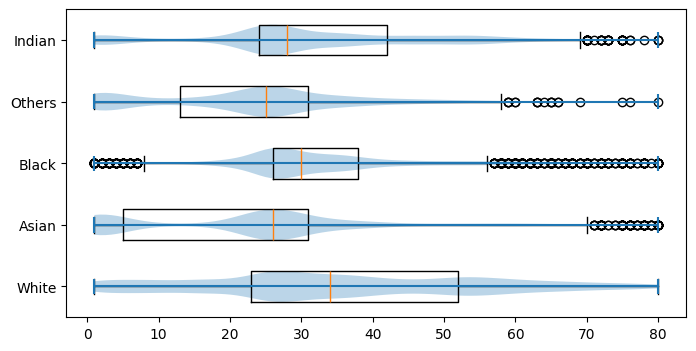

In [ ]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
            tick_labels= df.ethnicity.unique(),
            vert= False)
plt.violinplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
               vert= False);

----------

# Split data

In [ ]:
df_train_raw, df_test= train_test_split(df, test_size= 0.2,
                                        stratify= df.age, random_state= 42)
df_train, df_valid= train_test_split(df_train_raw, test_size= 0.2,
                                          stratify= df_train_raw.age, random_state= 42)

print(f'train: {df_train.shape}, valid: {df_valid.shape}, test: {df_test.shape}')

train: (14825, 4), valid: (3707, 4), test: (4633, 4)


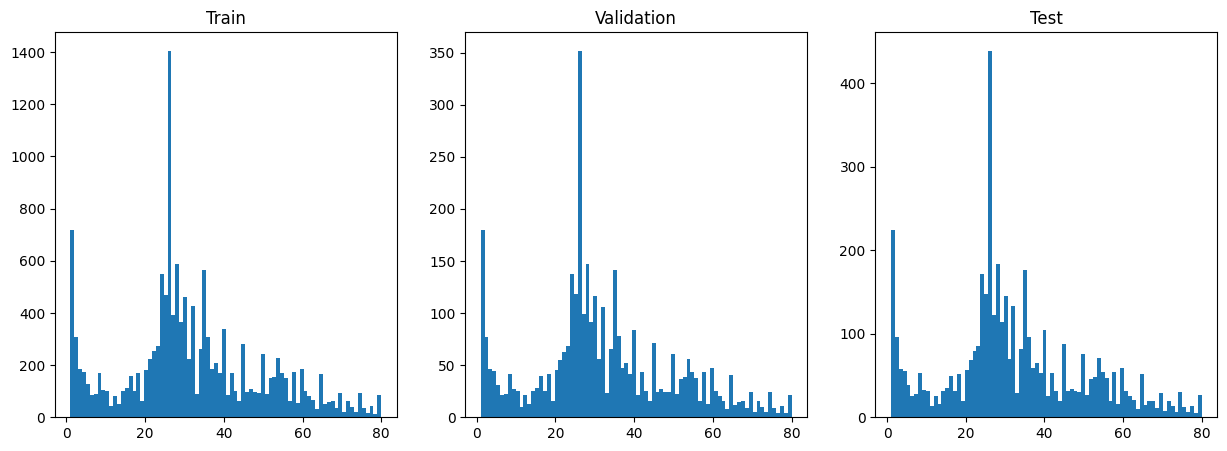

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

In [83]:
df_train.to_csv('/content/train_set.csv', index= False)
df_valid.to_csv('/content/valid_set.csv', index= False)
df_test.to_csv('/content/test_set.csv', index= False)

print('All CSV files created successfully.')

All CSV files created successfully.


--------

# Transform

In [81]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(brightness= 0.2, contrast= 0.2, saturation= 0.2, hue= 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
])

----------

# Custum dataset

In [123]:
class UTK_Dataset(Dataset):
  def __init__(self, root_dir, csv_file, transform):
    self.root_dir, self.csv_file, self.transform= root_dir, csv_file, transform
    self.data= pd.read_csv(self.csv_file)
    self.gender_map= {'Male': 0, 'Female': 1}
    self.race_map= {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample= self.data.iloc[idx, :]
    img_name= sample.image_name
    image= Image.open(os.path.join(self.root_dir, img_name))
    image= self.transform(image)

    age= torch.tensor(sample.age, dtype= torch.float32)
    gender= torch.tensor(self.gender_map[sample.gender], dtype= torch.int32)
    race= torch.tensor(self.race_map[sample.ethnicity], dtype= torch.int32)
    return image, age, gender, race

In [124]:
train_dataset= UTK_Dataset('/content/UTKFace', 'train_set.csv', train_transform)
valid_dataset= UTK_Dataset('/content/UTKFace', 'valid_set.csv', test_transform)
test_dataset= UTK_Dataset('/content/UTKFace', 'test_set.csv', test_transform)

In [126]:
smp= random.randint(0,len(train_dataset))
img, ag, gndr, rc= train_dataset[smp]
print(img.shape, ag, gndr, rc)

torch.Size([3, 128, 128]) tensor(38.) tensor(1, dtype=torch.int32) tensor(1, dtype=torch.int32)


----------

# DataLoader

In [127]:
train_loader= DataLoader(train_dataset, batch_size= 128, shuffle= True)
valid_loader= DataLoader(valid_dataset, batch_size= 256, shuffle= False)
test_loader= DataLoader(test_dataset, batch_size= 256, shuffle= False)

In [133]:
imgs, ags, gndrs, rcs= next(iter(train_loader));
print(imgs.shape, ags.shape, gndrs.shape, rcs.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128]) torch.Size([128]) torch.Size([128])
